## Imports and Setup

In [2]:
import os
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import sys
sys.path.insert(0, "../utils/")
import post_utils
import eval_utils
import config_utils
from calibrators import ECELoss

import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve, CalibrationDisplay

%load_ext autoreload
%autoreload 2

## Load Config Files

In [91]:
iso_code = "SEN"
cwd = os.path.dirname(os.getcwd())
data_config_file = os.path.join(cwd, "configs/data_configs/data_config_ISO_AF.yaml")
data_config = config_utils.load_config(data_config_file)

model_config_file = os.path.join(cwd, "configs/cnn_configs/satlas-aerial_swinb_si_01.yaml")
model_config = config_utils.load_config(model_config_file)

## Load Validation Results

In [93]:
val_output = post_utils.get_results(iso_code, model_config, phase="val")
#val_output_tempscaling = post_utils.get_results(
#    iso_code, model_config, phase="val", calibration="tempscaling"
#)
val_results = post_utils.get_evaluation(
    val_output, beta=2, optim_threshold=None
)
#val_output_isoreg = post_utils.get_results(
#    iso_code, model_config, phase="val", calibration="isoreg"
#)
val_output.head(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry,y_true,y_preds,y_probs
0,OSM-SEN-SCHOOL-00000052,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole élémentaire de Pilote,NaN,0,0.0,school,23,urban,val,POINT (-1614927.6902678423 1955753.4233859812),1,1,0.731047
1,OSM-SEN-SCHOOL-00000125,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole primaire Diass 3,NaN,0,0.0,school,21,urban,val,POINT (-1677620.044063711 1803663.7987482983),1,1,0.731058
2,OSM-SEN-SCHOOL-00000424,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Cheikh Dé Thialaw Seck,NaN,0,0.0,school,23,urban,val,POINT (-1642463.3094720996 1847259.1297881973),1,1,0.731058


## Load Test Results

In [94]:
test_output = post_utils.get_results(iso_code, model_config, phase="test")
#test_output_tempscaling = post_utils.get_results(
#    iso_code, model_config, phase="test", calibration="tempscaling"
#)
#test_output_isoreg = post_utils.get_results(
#    iso_code, model_config, phase="test", calibration="isoreg"
#)
test_output.head(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry,y_true,y_preds,y_probs
0,OSM-SEN-SCHOOL-00000075,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole d'Elinkine,NaN,0,0.0,school,13,rural,test,POINT (-1645442.8880473897 1541725.5277999148),1,1,0.731058
1,OSM-SEN-SCHOOL-00000161,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole 1,NaN,0,0.0,school,23,urban,test,POINT (-1319954.9528390914 1954650.5035527328),1,1,0.731058
2,OSM-SEN-SCHOOL-00000185,OSM,SEN,Senegal,Africa,Sub-Saharan Africa,Ecole Elémentaire Tivaouane 13,NaN,0,0.0,school,30,urban,test,POINT (-1648856.406144037 1841900.0392739468),1,1,0.731059


## Run Evaluation

In [95]:
val_results = post_utils.get_evaluation(
    val_output, beta=2, optim_threshold=None
)
#val_results_tempscaling = post_utils.get_evaluation(
#    val_output_tempscaling, beta=2, optim_threshold=None
#)
#val_results_isoreg = post_utils.get_evaluation(
#    val_output_isoreg, beta=2, optim_threshold=None
#)
for key, value in val_results.items():
    if 'optim' in key: print(f"{key}: {value:.4f}")
#print(f"Brier score: {val_results['brier_score']:.4f}") 
#print(f"Brier score temp scaling: {val_results_tempscaling['brier_score']:.4f}")
#print(f"Brier score isotonic reg: {val_results_isoreg['brier_score']:.4f}")

optim_threshold: 0.4951
fbeta_score_optim: 95.1253
precision_score_optim: 90.3537
recall_score_optim: 96.3979
f1_score_optim: 93.2780
overall_accuracy_optim: 95.4799
balanced_accuracy_optim: 95.7176


In [90]:
test_results = post_utils.get_evaluation(
    test_output, 
    beta=2, 
    optim_threshold=val_results['optim_threshold']
)
test_results_tempscaling = post_utils.get_evaluation(
    test_output_tempscaling, 
    beta=2, 
    optim_threshold=val_results_tempscaling['optim_threshold']
)
test_results_isoreg= post_utils.get_evaluation(
    test_output_isoreg, 
    beta=2,
    optim_threshold=val_results_isoreg['optim_threshold']
)
for key, value in test_results.items():
    if 'optim' in key: print(f"{key}: {value:.4f}")
print(f"Brier score: {test_results['brier_score']:.4f}") 
print(f"Brier score temp scaling: {test_results_tempscaling['brier_score']:.4f}")
print(f"Brier score isotonic reg: {test_results_isoreg['brier_score']:.4f}")

optim_threshold: 0.2722
fbeta_score_optim: 91.8919
precision_score_optim: 81.3397
recall_score_optim: 94.9721
f1_score_optim: 87.6289
overall_accuracy_optim: 91.3043
balanced_accuracy_optim: 92.2582
Brier score: 0.1033
Brier score temp scaling: 0.0847
Brier score isotonic reg: 0.0568


## Model Calibration

### Validation Set Calibration

In [ ]:
ece = ECELoss(n_bins=10)
ece.draw_reliability_graph(
    val_output["y_probs"].values, 
    val_output["y_true"].values
)

In [ ]:
ece.draw_reliability_graph(
    val_output_tempscaling["y_probs"], 
    val_output["y_true"].values
)

In [ ]:
ece.draw_reliability_graph(
    val_output_isoreg["y_probs"], 
    val_output["y_true"].values
)

### Test Set Calibration

In [ ]:
ece.draw_reliability_graph(
    test_output["y_probs"].values, 
    test_output["y_true"].values
)

In [ ]:
ece.draw_reliability_graph(
    test_output_tempscaling["y_probs"], 
    test_output["y_true"].values
)

In [ ]:
ece.draw_reliability_graph(
    test_output_isoreg["y_probs"], 
    test_output["y_true"].values
)

## Plot Results

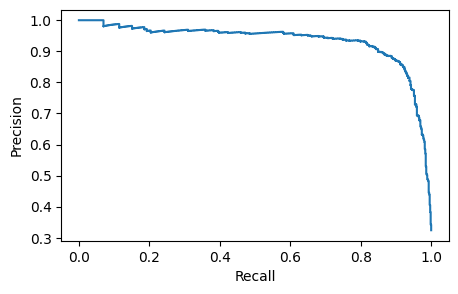

In [31]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
disp = PrecisionRecallDisplay(
    precision=test_results['precision_scores_'], 
    recall=test_results['recall_scores_']
)
disp.plot(ax=ax);

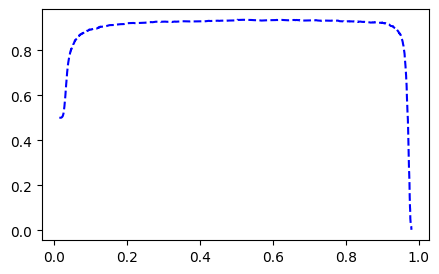

In [177]:
_, test_fscores = eval_utils.get_optimal_threshold(
    test_results['precision_scores_'], 
    test_results['recall_scores_'], 
    test_results['thresholds_'], 
    beta=1
)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test_results['thresholds_'], test_fscores[:-1], "b--");

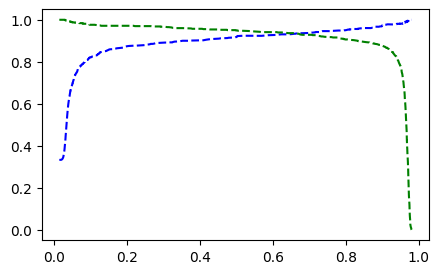

In [178]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(
    test_results['thresholds_'], 
    test_results['precision_scores_'][:-1], 
    "b--"
)
ax.plot(
    test_results['thresholds_'], 
    test_results['recall_scores_'][:-1], 
    "g--"
);